# *Ab* *initio* molecular dynamics of the vibrational motion of HF

### Part 1:  Generation of *ab* *initio* potential energy surfaces (PES)
We are going to construct what is often referred to as an *ab* *initio* potential energy surface of the diatomic
molecule hydrogen fluoride.  That is, we are going to use various electronic structure theories (Hartree-Fock theory (RHF), 2nd-order perturbation theory (MP2), and Coupled Cluster theory with single and double substitutions (CCSD)) to compute the electronic energy at different geometries of a simple diatomic molecule.  The same basis set (correlation consistent polarized triple-zeta, cc-pVTZ) will be used for all calculations.  We will use Psi4numpy to facilitate the electronic structure calculations, and then the interpolation capabilities of scipy to simplify the evalution of the potential energy at separations for which we did not explicitly evaluate the electronic energy.  We will also use scipy to differentiate the interpolated potential energy surface to obtain the forces acting on the atoms at different separations.  

We will start by importing the necessary libraries:

In [9]:
import numpy as np
import psi4
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline

We will use a template for the z-matrix which will allow us to automate the
specification of the bond length of our HF molecule for easy computation of our potential
energy surface.

In [10]:
### template for the z-matrix
mol_tmpl = """H
F 1 **R**"""

Now let's create arrays for the bond length and energies at each bond length
for three different levels of theory (RHF, MP2, and CCSD).  Let's have our bond lengths
spane 0.5 - 2.25 $\overset{\circ}{A}$; note that should use finer resolution for short bondlengths than our longer bondlengths because we want to be sure we accurately represent the minimum energy point on the PES!

In [11]:
''' create arrays in this cell! '''
### We will probably forget about the molecules array, so let's have it pre-declared!
molecules = []
r_array = [0.5, 0.592105263, 0.684210526, 0.776315789, 0.868421053, 0.960526316, 1.052631579, 1.144736842, 1.236842105, 1.328947368, 1.421052632, 1.513157895, 1.605263158, 1.697368421, 1.789473684, 1.881578947, 1.973684211, 2.065789474, 2.157894737, 2.25]
RHF_E_array = []
MP2_E_array = []
CCSD_E_array = []

### make list of numbers 0.5 - 2.5 angstrom
#r_array = [0.5, 0.592105263, 0.684210526, 0.776315789, 0.868421053, 0.960526316, 1.052631579, 1.144736842, 1.236842105, 1.328947368, 1.421052632, 1.513157895, 1.605263158, 1.697368421, 1.789473684, 1.881578947, 1.973684211, 2.065789474, 2.157894737, 2.25]
#r_array_2 = np.linspace(0.5, 2.5, 20)
#print(r_array_2)

Now we will loop over the elements of our r_array, compute the energies at each level of theory for all bond lengths, and store them in their respective arrays.

In [12]:
### loop over the different bond-lengths, create different instances
### of HF molecule
for r in r_array:
    molecule = psi4.geometry(mol_tmpl.replace("**R**", str(r)))
    molecules.append(molecule)
    
### loop over instances of molecules, compute the RHF, MP2, and CCSD
### energies and store them in their respective arrays
for mol in molecules:
    energy = psi4.energy("SCF/cc-pVTZ", molecule=mol)
    RHF_E_array.append(energy)
    energy = psi4.energy("MP2/cc-pVTZ", molecule=mol)
    MP2_E_array.append(energy)
    energy = psi4.energy("CCSD/cc-pVTZ",molecule=mol)
    CCSD_E_array.append(energy)


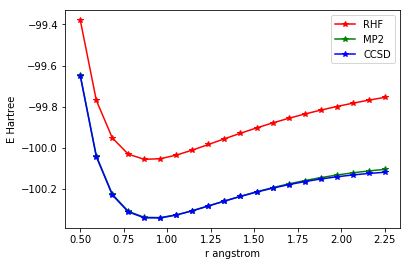

In [15]:
plt.plot(r_array, RHF_E_array, '-r*', label='RHF')
plt.plot(r_array, MP2_E_array, '-g*', label='MP2')
plt.plot(r_array, CCSD_E_array, '-b*', label='CCSD')
plt.legend()
plt.xlabel('r angstrom')
plt.ylabel('E Hartree')
plt.show()

Now that you have the raw data, we will interpolate this data using cubic splines.  This will permit us to 
estimate the potential energy at any arbitrary separation between 0.5 and 2.25 Angstroms.

The general syntax for creating a cubic spline object is as follows:

`spline = InterpolatedUnivariateSpline(x-data, y-data, k=3)`

#### Note on units
The energies we obtained from psi4 are in Hartrees, which are the atomic unit of energy.  We have so far been specifying our separation in Angstroms (**not the atomic unit of length**) so we are in a mixed unit system.  When we generate our spline, we will use an array of bond lengths in atomic units as the x-data and the energies in atomic units as the y-data, which will yield a PES purely in atomic units.  Therefore, the first thing we will do before creating the spline is to create an array of bond lengths in atomic units (~1.89 * bond lengths in Angstroms is the bond length in atomic units); we will then create three cubic splines (RHF_E_Spline, MP2_E_Spline, CCSD_E_SPline) that hold the PES data in atomic units for the three levels of theory.



In [25]:
''' Create array of bond lengths in atomic units called r_array_au and fit PESs to splines in this cell! '''
r_array_au = []
for r in r_array:
    r_array_au.append(r*1.89)
print(r_array_au)

### RHF Spline
RHF_E_Spline = InterpolatedUnivariateSpline(r_array_au, RHF_E_array, k=3)
### MP2 Spline
MP2_E_Spline = InterpolatedUnivariateSpline(r_array_au, MP2_E_array, k=3)
## CCSD Spline
CCSD_E_Spline = InterpolatedUnivariateSpline(r_array_au, CCSD_E_array, k=3)

[0.945, 1.11907894707, 1.29315789414, 1.4672368412099999, 1.64131579017, 1.81539473724, 1.98947368431, 2.1635526313799995, 2.33763157845, 2.51171052552, 2.68578947448, 2.85986842155, 3.03394736862, 3.2080263156899997, 3.38210526276, 3.5561842098299996, 3.7302631587899997, 3.904342105859999, 4.07842105293, 4.2524999999999995]


Now we can plot the splines against the PES data to make sure our splines were generated properly.

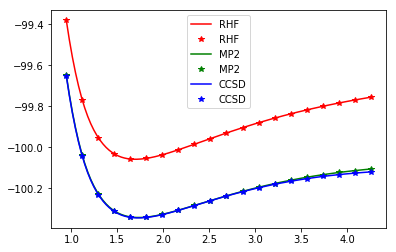

In [26]:
### form a much finer grid to evaluate spline object at
r_fine = np.linspace(0.5*1.89,2.25*1.89,200)

### compute the interpolated/extrapolated values for RHF Energy on this grid
RHF_E_fine = RHF_E_Spline(r_fine)

### compute the interpolated/extrapolated values for RHF Energy on this grid
MP2_E_fine = MP2_E_Spline(r_fine)

### compute the interpolated/extrapolated values for RHF Energy on this grid
CCSD_E_fine = CCSD_E_Spline(r_fine)


### plot the interpolated data with lines against computed data in *'s
plt.plot(r_fine, RHF_E_fine, 'red', r_array_au, RHF_E_array, 'r*', label='RHF')
plt.plot(r_fine, MP2_E_fine, 'green', r_array_au, MP2_E_array, 'g*', label='MP2')
plt.plot(r_fine, CCSD_E_fine, 'blue', r_array_au, CCSD_E_array, 'b*', label='CCSD')
plt.legend()
plt.show()

### Part 2:  Computation of Forces and related quantities and their importance in Newton's law
We can derive a number of important quantities just from the potential energy surfaces we have computed.  For example, we estimate the equilibrium bond length by finding the separation at which the potential is minimum; note this would also be the position that the force goes to zero:
\begin{equation}
\frac{d}{dr} V(r_{eq}) = -F(r_{eq}) = 0.
\end{equation}

The force as a function of separation plays a significant role in the vibrational motion of the molecule, as we will see shortly.  

First we will compute the forces at each level of theory, storing them in new spline
objects called RHF_Force, MP2_Force, and CCSD_Force. We can use the fact
that the spline objects (which we previously created) can be directly differentiated using the following syntax:

`spline_derivative = spline.derivative()`

Once computed, plot each spline against the r_fine array previously created!
#### What unit system do you think the forces are in?

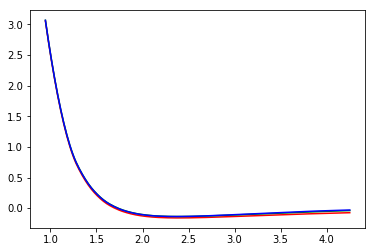

In [28]:
''' Differentiate splines and plot resulting forces in this cell! '''
RHF_Force_Spline = RHF_E_Spline.derivative()
MP2_Force_Spline = MP2_E_Spline.derivative()
CCSD_Force_Spline = CCSD_E_Spline.derivative()

RHF_Force_fine = -1*RHF_Force_Spline(r_fine)
MP2_Force_fine = -1*MP2_Force_Spline(r_fine)
CCSD_Force_fine = -1*CCSD_Force_Spline(r_fine)

plt.plot(r_fine, RHF_Force_fine, 'red', label='RHF Force')
plt.plot(r_fine, MP2_Force_fine, 'green', label='MP2 Force')
plt.plot(r_fine, CCSD_Force_fine, 'blue', label='CCSD Force')

#### Equilibrium bond length 
Next we will find where the minimum of the potential energy surfaces are and use that
to find the equilibrium bond length, making use of numpy's argmin function to find the
index corresponding to the minimum value in a numpy array:

In [30]:
### Find Equilibrium Bond-Lengths for each level of theory
RHF_Req_idx = np.argmin(RHF_E_fine)
MP2_Req_idx = np.argmin(MP2_E_fine)
CCSD_Req_idx = np.argmin(CCSD_E_fine)

### find the value of the separation corresponding to that index
RHF_Req = r_fine[RHF_Req_idx]
MP2_Req = r_fine[MP2_Req_idx]
CCSD_Req = r_fine[CCSD_Req_idx]

### print equilibrium bond-lengths at each level of theory!
print(" Equilibrium bond length at RHF/cc-pVDZ level is ",RHF_Req, "atomic units")
print(" Equilibrium bond length at MP2/cc-pVDZ level is ",MP2_Req, "atomic units")
print(" Equilibrium bond lengthat CCSD/cc-pVDZ level is ",CCSD_Req, "atomic units")

print("RHF Req ", RHF_Req/1.89, "Angstroms")
print("MP2 Req is", MP2_Req/1.89, "Angstroms")

 Equilibrium bond length at RHF/cc-pVDZ level is  1.692927135678392 atomic units
 Equilibrium bond length at MP2/cc-pVDZ level is  1.7261683417085427 atomic units
 Equilibrium bond lengthat CCSD/cc-pVDZ level is  1.7261683417085427 atomic units
RHF Req  0.8957286432160805 Angstroms
MP2 Req is 0.913316582914573 Angstroms


#### At this point, take a moment to compare your equilibrium bond length by level of theory.  Which equilibrium bond length do you expect to be most trustworthy?  Is it the case that this method produced the **best** equilibrium bond length in this case?  Note that the experimental bond length of HF is ~0.92 $\overset{\circ}{A}$.

   

#### Harmonic Frequency 
You might have learned that the Harmonic Oscillator potential, which is a reasonable model for the vibrational motion of diatomic molecules near their equilibrium bond length, is given by
\begin{equation}
V(r) = \frac{1}{2} k (r-r_{eq})^2 + V_0
\end{equation}
and that the vibrational frequency of the molecule within the Harmonic oscillator model is given by
\begin{equation}
\nu = \frac{1}{2\pi}\sqrt{\frac{k}{\mu}}
\end{equation}
where $\mu$ is the reduced mass of the molecule and $k$ is known as the force constant.  
We can estimate the force constant as
\begin{equation}
k = \frac{d^2}{dr^2} V(r_{eq}),
\end{equation}
and the reduced mass of HF is defined as
\begin{equation}
\mu = \frac{m_H \cdot m_F}{m_H + m_F},
\end{equation}
where $m_H$ and $m_F$ are the masses of Hydrogen and Fluoride, respectively.

Let's go ahead and get the force constants at each level of theory, print the values, 
and estimate the potential energy within the Harmonic approximation!  Just like we were able to differentiate our PES splines to get a force spline, we can differentiate a force splines to get curvature splines (which we can call RHF_Curvature, MP2_Curvature, and CCSD_Curvature); the force constant will then be the curvature evaluated at the equlibrium bond length.

#### Can we use the same equilibrium bond length for all three curvatures?  Why or why not?

In [ ]:
''' Differentiate force splines to get curvatures and determine force constants in this cell!'''

Now that we have the force constants, let's define three different arrays (RHF_Harm_Pot, MP2_Harm_Pot, and CCSD_Harm_Pot) that store the harmonic potentials at each level of theory evaluated at the different bond lengths (in atomic units) stored in the array r_fine; recall the definition of the Harmonic potential is 
\begin{equation}
V(r) = \frac{1}{2} k (r-r_{eq})^2 + V_0,
\end{equation}
where we can use $E(r_{eq})$ as $V_0$.

In [ ]:
''' Create arrays of Harmonic potentials in this cell! '''

Let's plot the resulting Harmonic potentials against the *ab* *initio* potentials near the equilibrium geometry

In [ ]:
### plot RHF harmonic potential vs RHF ab initio potential!
plt.plot(r_fine, RHF_Harm_Pot, 'red', label='Harmonic')
plt.plot(r_fine, RHF_E_fine, 'b--', label='ab initio' )
### these limits were chosen to zoom in on region of the RHF PES that is approximately
### harmonic
plt.xlim(1.0, (1.69+0.69))
plt.ylim(-100.1,-99.6)
plt.legend()
plt.show()

Finally, let's actually estimate the fundamental vibrational frequency of the molecule 
within this model using the force constant and the reduced mass of the molecule.

####  What is the reduced mass of the HF molecule in atomic units?

#### Use your Harmonic force constants to estimate the vibrational frequency of HF and compare the values obtained from each level of theory.  Which frequency do you think should be the most trusthworthy?  Is it the case that this method produced the best frequency in this case?  Note that the experimental vibrational frequency of HF is 124 THz.

In [ ]:
''' Compute reduced mass of HF in atomic units and compute vibrational frequencies in atomic units in this cell!'''

### Part 3: Solving Newton's equation of motion to simulate the dynamics
Next, we want to actually simulate the dynamics of the HF molecule on these *ab* *initio* potential energy surfaces.  To do so, we need to solve Newton's equations of motion subject to some initial condition for the position (separation) and momentum (in a relative sense) of the particles.  Newton's equations can be written
\begin{equation}
F(r) = \mu \frac{d^2}{dr^2}
\end{equation}
where $\mu$ is the reduced mass in atomic units and $F(r)$ is the Force vs separation in atomic units that was determined previously.  

#### What will be the accelation of the bond stretch when H is separated by F by 3 atomic units?  You can express your acceleration in atomic units, also.



In [ ]:
""" Compute acceleration at RHF, MP2, CCSD levels when HF is displaced by 3 atomic units in this cell! """

#### Numerically solving Newton's equation of motion 
If the acceleration, position, and velocity of the bond stretch coordinate are known at some instant in 
time $t_i$, then the position and velocity can be estimated at some later time $t_{i+1} = t_i + \Delta t$:
\begin{equation}
r(t_i + \Delta t) = r(t_i) + v(t_i)\Delta t + \frac{1}{2}a(t_i)\Delta t^2
\end{equation}
and
\begin{equation}
v(t_i + \Delta t) = v(t_i) + \frac{1}{2} \left(a(t_i) + a(t_i + \Delta t)  \right) \Delta t.
\end{equation}
This prescription for updating the velocities and positions is known as the Velocity-Verlet algorithm.  
Note that we need to perform 2 force evaluations per Velocity-Verlet iteration: one corresponding
to position $r(t_i)$ to update the position, and then a second time at the updated position $r(t_i + \Delta t)$
to complete the velocity update.  

We will create a function called Velocity_Verlet that takes the arguments r_curr, v_curr, mu, force_spline, and timestep and returns a 2-element array containing the updated position (r) and velocity (v) value.

In [ ]:
''' Velocity Verlet function goes in this cell! '''

### Validating Velocity-Verlet algorithm with the Harmonic Oscillator
Newton's equation of motion can be solved analytically for the Harmonic oscillator, and we can use this fact to validate our Velocity-Verlet algorithm (which provides an *approximate* solution to Newton's equation of motion for arbitrary potentials).  That is,
the vibrational motion of a diatomic subject to a Harmonic potential predicted 
by the Velocity-Verlet algorithm should closely match the analytical solution. Analytically, 
the bond length as a function of time for a diatomic experiencing a harmonic potential is given by
\begin{equation}
r(t) = A \: {\rm sin}\left(\sqrt{\frac{k}{\mu}} t + \phi \right) + r_{eq},
\end{equation}
where $A = \frac{r(0)}{{\rm sin}(\phi)}$, $r(0)$ is the initial separation, and $\phi$ is the initial phase of the cycle; note that corresponding to this initial separation is 
an initial velocity given by 
\begin{equation}
v(0) = A \: \sqrt{\frac{k}{\mu}} {\rm cos}\left( \phi \right).
\end{equation}

Let's define a function harmonic_position that takes arguments of $\sqrt{\frac{k}{\mu}}$ (om), $A$ (amp), $\phi$ (phase), $r_{eq}$ (req), and time (t), and returns the separation. 


In [ ]:
''' Analytic solution to Harmonic Oscillator r(t) goes here! '''

The following code block will call the Velocity Verlet algorithm using 
the RHF Harmonic potential 10,000 times with a 
timestep of 0.1 atomic units per timestep and will compare the resulting trajectory of bond length vs time (all in atomic units) to the analytic result for the Harmonic oscillator; we will initiate the bond length as being 0.2 atomic units **longer** than $r_{eq}$ with an initial phase of $\frac{\pi}{4}$.

In [ ]:
### how many updates do you want to perform?
N_updates = 10000

### establish time-step for integration to be 0.02 atomic units... this is about 0.0005 femtoseconds
### so total time is 200000*0.02 atomic units of time which is ~9.6e-13 s, or 960 fs
dt = 0.1

### results from VV algorithm
hr_vs_t = np.zeros(N_updates)
hv_vs_t = np.zeros(N_updates)
### analytic result for r(t)
ar_vs_t = np.zeros(N_updates)
### array to store time in atomic units
t_array = np.zeros(N_updates)

### establish some constants relevant for analytic solution
### harmonic freq
om = np.sqrt(RHF_k/mu)
### initial displacement 
x0 = 0.2
### amplitude for analytic solution
Amp = x0/(np.sin(np.pi/4))
### initial velocity
v0 = Amp * om * np.cos(np.pi/4)

hr_vs_t[0] = RHF_Req+x0
hv_vs_t[0] = v0

### We need a spline object for the harmonic force to pass to the Velocity Verlet algorithm,
### let's get that now!

### spline for Harmonic potential using RHF_k
RHF_Harm_Pot_Spline = InterpolatedUnivariateSpline(r_fine, RHF_Harm_Pot, k=3)
### RHF harmonic force
RHF_Harm_Force = RHF_Harm_Pot_Spline.derivative()


### first Velocity Verlet update
result_array = Velocity_Verlet(hr_vs_t[0], hv_vs_t[0], mu, RHF_Harm_Force, dt)
### first analytic result
ar_vs_t[0] = harmonic_position(om, Amp, np.pi/4, RHF_Req, 0)
### do the update N_update-1 more times
for i in range(1,N_updates):
    ### store current time
    t_array[i] = dt*i
    ### Compute VV update
    result_array = Velocity_Verlet(result_array[0], result_array[1], mu, RHF_Harm_Force, dt)
    ### store results from VV update
    hr_vs_t[i] = result_array[0]
    hv_vs_t[i] = result_array[1]
    ### compute and store results from analytic solution
    ar_vs_t[i] = harmonic_position(om, Amp, np.pi/4, RHF_Req, dt*i)

### Plot result and compare!
plt.plot(t_array, hr_vs_t, 'red', label="Velocity Verlet")
plt.plot(t_array, ar_vs_t, 'b--', label="Analytic")
plt.legend()
plt.show()


Now let's simulate the vibrational motion of HF subject to the *ab* *initio* forces we computed earlier and compare them to the Harmonic motion; recall we have already obtained spline objects for RHF, MP2, and CCSD forces called RHF_Force, MP2_Force, and CCSD_Force.
We will also initialize the simulations using the same values as we did with the Harmonic case to aid our comparison.

In [ ]:
""" Create new arrays for r(t) and v(t) for HF subject to ab initio forces and 
    run velocity verlet N_updates times, plot results against harmonic results from
    previous cell! """

#### How are the dynamics different when the *ab* *initio* forces are used?  Try to identify at least two quantitative ways in which you can distinguish the harmonic motion from the motion deriving from the *ab* *initio* forces.  

#### Can you estimate the frequency from the *ab* *initio* trajectories?  How does this frequency compare with the Harmonic approximation and with the experimental value?

### For further consideration: What makes a "sensible range of values" for position and velocity?

In this case, we will initialize the position to be a random number between 1.0 and 4.0; for the velocity, we will use the fact that we can estimate the expectation value of kinetic energy for a very similar system (the Harmonic oscillator) in the ground state as follows:
\begin{equation}
\langle T \rangle = \frac{1}{2} E_g,
\end{equation}
where $E_g$ is the ground state of the Harmonic oscillator (this is making use of the Virial theorem).  We can easily
find the ground state energy in the Harmonic oscillator approximation of $HF$ using our frequency calculation described above as
\begin{equation}
E_g = \frac{1}{2} h \nu,
\end{equation}
which implies the kinetic energy expectation value is
\begin{equation}
\langle T \rangle = \frac{h}{8 \pi} \sqrt{\frac{k}{\mu}}.
\end{equation}
Since we can say classically that the kinetic energy is given by $T = \frac{1}{2}\mu v^2$, we can estimate the velocity of the bond stretch as follows:
\begin{equation}
v = \sqrt{\frac{2 \langle T \rangle}{\mu}} = \sqrt{ \frac{\hbar \sqrt{\frac{k}{\mu}}}{2\mu}}
\end{equation}
where we have simplified using the fact that $\hbar = \frac{h}{2\pi}$ ($\hbar$ has the value 1 in the atomic unit system we are using up to this point!).  We will assume that a reasonable
range of velocities spans plus or minus 3 times this "ground-state" velocity.


In [ ]:
### define "ground-state" velocity for each level of theory
v_RHF = np.sqrt( np.sqrt(RHF_k/mu)/(2*mu))
v_MP2 = np.sqrt( np.sqrt(MP2_k/mu)/(2*mu))
v_CCSD = np.sqrt( np.sqrt(CCSD_k/mu)/(2*mu))


### get random position and velocity for RHF HF within a reasonable range
#r_init = np.random.uniform(0.75*RHF_Req,2*RHF_Req)
r_init = RHF_Req
v_init = np.random.uniform(-2*v_RHF,2*v_RHF)

### print initial position and velocity
print("Initial separation is ",r_init, "atomic units")
print("Initial velocity is   ",v_init, "atomic units")


### get initial force on the particle based on its separation
RHF_F_init = -1*RHF_Force(r_init)
print("Initial Force is ", RHF_F_init, "atomic units")
